In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

data_path_root = '/data/wumin/dataset/mnist/'

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root=data_path_root, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root=data_path_root, train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [5]:
class CVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(CVAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim+10, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim+10, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        label = x[:,-10:]
        z_l = torch.concatenate((z, label), dim=1)
        return self.decoder(z_l), mu, log_var


In [63]:
# build model
cvae = CVAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    cvae.cuda()
print(cvae)

VAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=12, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [69]:
optimizer = optim.Adam(cvae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD, BCE, KLD

In [73]:
def train(epoch):
    cvae.train()
    train_loss, bce_loss, kld_loss = 0, 0, 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.view(-1, 784).cuda()
        label = label.cuda()
        label = F.one_hot(label, num_classes=10)
        input = torch.concatenate((data, label), dim=1)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = cvae(input)
        loss, bce, kld = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        bce_loss += bce.item()
        kld_loss += kld.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} BCE: {:.6f} KLD: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data),bce.item() / len(data),kld.item() / len(data)))
    l = len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f} BCE: {:.4f} KLD: {:.4f}'.format(epoch,
        train_loss / l, bce_loss / l, kld_loss / l))
    if epoch == 1:
        save_image(data.view(-1, 1, 28,28), './samples/cvae/real.png', nrow=10)

In [76]:
def test(epoch=None):
    cvae.eval()
    test_loss, bce_loss, kld_loss = 0, 0, 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.view(-1, 784).cuda()
            label = label.cuda()
            label = F.one_hot(label, num_classes=10)
            input = torch.concatenate((data, label), dim=1)
            recon, mu, log_var = cvae(input)
            
            # sum up batch loss
            loss, bce, kld =  loss_function(recon, data, mu, log_var)
            test_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
    test_loss /= len(test_loader.dataset)
    bce_loss /= len(test_loader.dataset)
    kld_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f} BCE: {:.4f} KLD: {:.4f}'.format(test_loss, bce_loss, kld_loss))
    if epoch:
        save_image(recon.view(-1,1,28,28), './samples/cvae/reconstructed_{}.png'.format(epoch),nrow=10)

In [77]:
for epoch in range(1, 31):
    train(epoch)
    test(epoch)

torch.save(cvae, './cvae.pth')

Train Epoch: 1 [0/60000 (0%)]	Loss: 132.241201 BCE: 127.765996 KLD: 4.475201
Train Epoch: 1 [10000/60000 (17%)]	Loss: 133.372070 BCE: 128.786797 KLD: 4.585269
Train Epoch: 1 [20000/60000 (33%)]	Loss: 137.953477 BCE: 133.306699 KLD: 4.646773
Train Epoch: 1 [30000/60000 (50%)]	Loss: 135.972539 BCE: 131.497852 KLD: 4.474688
Train Epoch: 1 [40000/60000 (67%)]	Loss: 141.483154 BCE: 136.676328 KLD: 4.806831
Train Epoch: 1 [50000/60000 (83%)]	Loss: 134.264971 BCE: 130.044668 KLD: 4.220299
====> Epoch: 1 Average loss: 135.2668 BCE: 130.8030 KLD: 4.4638
====> Test set loss: 134.2154 BCE: 129.7350 KLD: 4.4804
Train Epoch: 2 [0/60000 (0%)]	Loss: 138.010342 BCE: 133.417266 KLD: 4.593072
Train Epoch: 2 [10000/60000 (17%)]	Loss: 133.960889 BCE: 129.303750 KLD: 4.657142
Train Epoch: 2 [20000/60000 (33%)]	Loss: 129.691084 BCE: 125.021982 KLD: 4.669099
Train Epoch: 2 [30000/60000 (50%)]	Loss: 134.062051 BCE: 129.433252 KLD: 4.628795
Train Epoch: 2 [40000/60000 (67%)]	Loss: 129.155723 BCE: 124.515420 KL

In [79]:
with torch.no_grad():
    z = torch.randn(100, 2).cuda()
    label = torch.randint(0, 10,(100,)).cuda()
    label = F.one_hot(label, num_classes=10)
    z_l = torch.concatenate((z,label), dim=1)
    sample = cvae.decoder(z_l).cuda()
    
    save_image(sample.view(100, 1, 28, 28), './samples/cvae/sampled_random' + '.png', nrow=10)

In [ ]:
with torch.no_grad():
    z = torch.randn(100, 2).cuda()
    label = []
    for i in range(10):
        label.extend([i for j in range(10)])
    label = torch.tensor(label).cuda()
    label = F.one_hot(label, num_classes=10)
    z_l = torch.concatenate((z,label), dim=1)
    sample = cvae.decoder(z_l).cuda()

    save_image(sample.view(-1, 1, 28, 28), './samples/cvae/sampled_uniform.png', nrow=10)

In [94]:
def generate(num):
    with torch.no_grad():
        z = torch.tensor([[x,y] for x in torch.arange(-2.0,2.1, 0.2)
                   for y in torch.arange(-2.0,2.1, 0.2)]).cuda()
        label = torch.tensor([num for _ in range(21*21)]).cuda()
        label = F.one_hot(label, num_classes=10)
        z_l = torch.concatenate((z,label), dim=1)

        sample = cvae.decoder(z_l).cuda()
        save_image(sample.view(-1, 1, 28, 28), './samples/cvae/sampled_num{}.png'.format(num), nrow=21)

for i in range(10):
    generate(i)

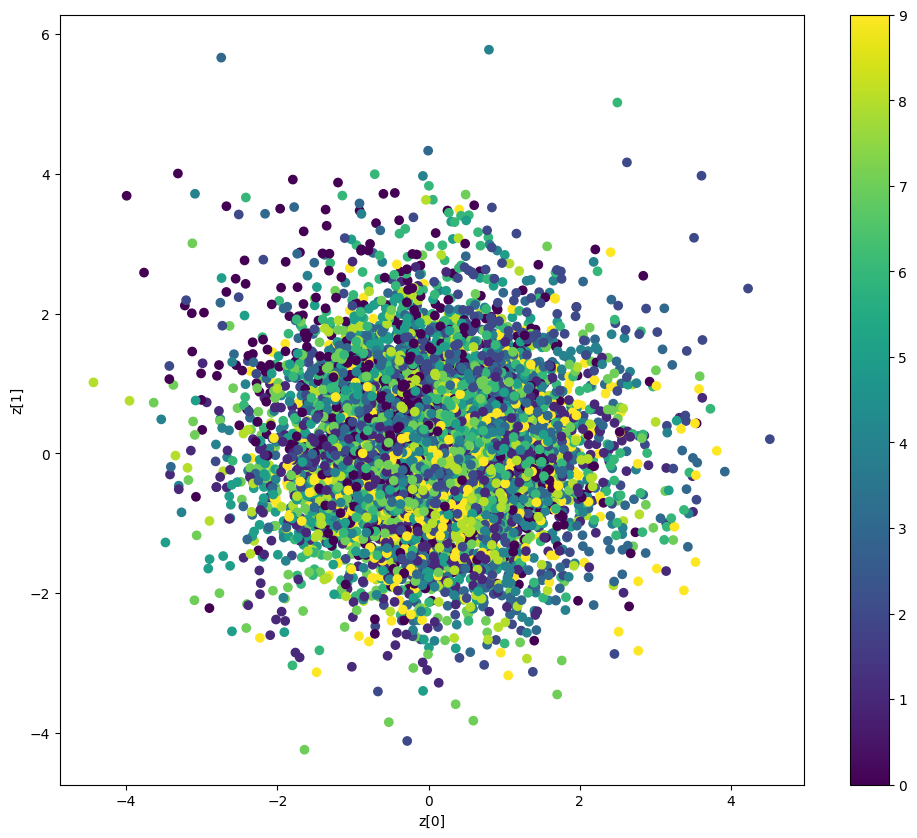

In [20]:
cvae = torch.load('./cvae.pth')
import matplotlib.pyplot as plt

dataset = datasets.MNIST(root=data_path_root, train=True, transform=transforms.ToTensor(), download=False)
loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=60000, shuffle=False)
# display a 2D plot of the digit classes in the latent space
with torch.no_grad():
    for data, label in loader:
        data = data.view(-1, 784).cuda()
        label = label.cuda()
        label = F.one_hot(label, num_classes=10)
        input = torch.concatenate((data, label), dim=1)
        mu, _ = cvae.encoder(input)
        mu = mu.cpu()
        label = torch.argmax(label, dim=1).cpu() # one hot to label
        plt.figure(figsize=(12,10))
        plt.scatter(mu[:, 0], mu[:, 1], c=label)
        plt.colorbar()
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show()
        break